<a href="https://colab.research.google.com/github/SanjayShetty01/PredictingOpeningPriceNifty50/blob/main/PredictingOpeningPriceUsingNewsSentimentAndOtherIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download the necessay packages


We would be downloading the packages from pip.



* keras-tuner: For hyperparameter tuning of Neural Networks.
* vaderSentiment: For Sentimental anaylsis.
* yfinance: To import the Index Data. 
* yellowbrick : For Machine Learning Visualzations.

In [246]:
!pip install keras-tuner
!pip install vaderSentiment
!pip install yfinance
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load the necessary libraries

In [247]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from yellowbrick.model_selection import validation_curve 
from yellowbrick.model_selection import FeatureImportances
import sklearn
from sklearn import metrics
plt.style.use('seaborn')
%load_ext google.colab.data_table
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
import keras_tuner as kt

np.random.seed(100) #Setting up the seed

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


### Load the dataset

The data for the project was cleanned and preprocessed and stored in my Github repo, please do look in [my repo](https://github.com/SanjayShetty01/Prediction_of_Stock_Closing_price_Using_Sentimental_Analysis) for more on it. 

In [248]:
# News Headlines data
News_Headlines = pd.read_csv('https://github.com/SanjayShetty01/PredictingOpeningPriceNifty50/blob/main/News_Headlines.csv?raw=true')

In [249]:
# NIFTY 50 dataset

#ticker Symbol
tickerSymbol = '^NSEI'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
nifty50Data = tickerData.history(period='1d', start='2014-01-28', end='2017-06-30')

nifty50Data.head()

Open         High          Low        Close  Volume  \
Date                                                                     
2014-01-28  6131.850098  6163.600098  6085.950195  6126.250000  184100   
2014-01-29  6161.000000  6170.450195  6109.799805  6120.250000  146700   
2014-01-30  6067.000000  6082.850098  6027.250000  6073.700195  208100   
2014-01-31  6082.750000  6097.850098  6067.350098  6089.500000  146700   
2014-02-03  6058.799805  6074.850098  5994.450195  6001.799805  134900   

            Dividends  Stock Splits  
Date                                 
2014-01-28          0             0  
2014-01-29          0             0  
2014-01-30          0             0  
2014-01-31          0             0  
2014-02-03          0             0

In [250]:
# Nikkie225 dataset (Japan's Stock Index)

#ticker Symbol
tickerSymbol = '^N225'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
Nikkei225 = tickerData.history(period='1d', start='2014-01-28', end='2017-06-30')

Nikkei225.head()

Open          High           Low         Close     Volume  \
Date                                                                            
2014-01-28  15038.639648  15088.120117  14952.830078  14980.160156  183100000   
2014-01-29  15164.339844  15383.910156  15159.919922  15383.910156  164800000   
2014-01-30  15112.700195  15112.700195  14853.830078  15007.059570  221200000   
2014-01-31  15132.230469  15143.879883  14764.570312  14914.530273  217400000   
2014-02-03  14788.559570  14846.929688  14615.049805  14619.129883  202800000   

            Dividends  Stock Splits  
Date                                 
2014-01-28          0             0  
2014-01-29          0             0  
2014-01-30          0             0  
2014-01-31          0             0  
2014-02-03          0             0

In [251]:
# S&P 500 (US stock Index)

#ticker Symbol
tickerSymbol = '^GSPC'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
SP500 = tickerData.history(period='1d', start='2014-01-28', end='2017-06-30')

SP500.head()

Open         High          Low        Close      Volume  \
Date                                                                         
2014-01-28  1783.000000  1793.869995  1779.489990  1792.500000  3437830000   
2014-01-29  1790.150024  1790.150024  1770.449951  1774.199951  3964020000   
2014-01-30  1777.170044  1798.770020  1777.170044  1794.189941  3547510000   
2014-01-31  1790.880005  1793.880005  1772.260010  1782.589966  4059690000   
2014-02-03  1782.680054  1784.829956  1739.660034  1741.890015  4726040000   

            Dividends  Stock Splits  
Date                                 
2014-01-28          0             0  
2014-01-29          0             0  
2014-01-30          0             0  
2014-01-31          0             0  
2014-02-03          0             0

### A Look into both the datasets

Cleaning all the datasets

1. News Headlines Dataset

In [252]:
News_Headlines.head()

Unnamed: 0                                          Headlines  \
0           0  Production outages in Asia lend slight support...   
1           1  UK consumers suffer longest decline in spendin...   
2           2  Market Now: Gammon Infra, GVK Power Infra surg...   
3           3  Global markets: Brightening economy sets euro ...   
4           4  Relying on schemes like Swachh Bharat alone wo...   

             Date_Time  
0  2017-06-30 15:03:00  
1  2017-06-30 15:03:00  
2  2017-06-30 15:01:00  
3  2017-06-30 15:00:00  
4  2017-06-30 14:59:00

In [253]:
News_Headlines.drop(columns='Unnamed: 0', inplace=True)  # Remove the 'Unnamed: 0' column

In [254]:
News_Headlines.shape

(422092, 2)

In [255]:
News_Headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422092 entries, 0 to 422091
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Headlines  422087 non-null  object
 1   Date_Time  421966 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [256]:
 # Converting to datetime format
 
News_Headlines['Date_Time'] = pd.to_datetime(News_Headlines.Date_Time,format = '%Y-%m-%d %H:%M:%S.%f')

In [257]:
News_Headlines.isnull().any() #Checking for NA values

Headlines    True
Date_Time    True
dtype: bool

In [258]:
News_Headlines.dropna(axis=0, inplace=True) # Removing the NA entries

News_Headlines.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


Headlines            Date_Time
count                                              421961               421961
unique                                             357179               276425
top     TRACK SENSEX, NIFTY LIVE: Who moved my market ...  1970-01-01 05:30:00
freq                                                  998                90319
first                                                 NaN  1970-01-01 05:30:00
last                                                  NaN  2017-06-30 15:03:00

Since the News headlines has some news headlines from  1970, we would remove the outlier data. 

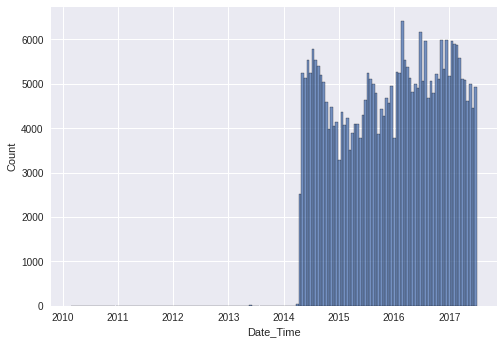

In [259]:
#Lets have a look at the data

news = News_Headlines[(News_Headlines['Date_Time'] > pd.Timestamp('2010-01-28'))]
sns.histplot(news['Date_Time'])

In [260]:
start_date = pd.Timestamp('2014-04-14 00:00:00')
end_date = pd.Timestamp('2018-01-01 00:00:00')

News_Headlines = News_Headlines[
                (News_Headlines['Date_Time']> start_date) &
                (News_Headlines['Date_Time']< end_date)
]

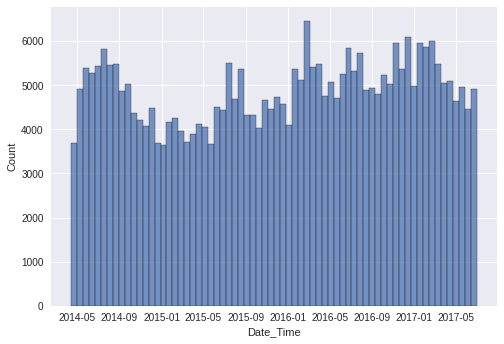

In [261]:
sns.histplot(News_Headlines['Date_Time'])

In [262]:
News_Headlines.shape

(331569, 2)

In [263]:
News_Headlines.head()

Headlines           Date_Time
0  Production outages in Asia lend slight support... 2017-06-30 15:03:00
1  UK consumers suffer longest decline in spendin... 2017-06-30 15:03:00
2  Market Now: Gammon Infra, GVK Power Infra surg... 2017-06-30 15:01:00
3  Global markets: Brightening economy sets euro ... 2017-06-30 15:00:00
4  Relying on schemes like Swachh Bharat alone wo... 2017-06-30 14:59:00

2. NIFTY 50 Dataset

In [264]:
nifty50Data.head()

Open         High          Low        Close  Volume  \
Date                                                                     
2014-01-28  6131.850098  6163.600098  6085.950195  6126.250000  184100   
2014-01-29  6161.000000  6170.450195  6109.799805  6120.250000  146700   
2014-01-30  6067.000000  6082.850098  6027.250000  6073.700195  208100   
2014-01-31  6082.750000  6097.850098  6067.350098  6089.500000  146700   
2014-02-03  6058.799805  6074.850098  5994.450195  6001.799805  134900   

            Dividends  Stock Splits  
Date                                 
2014-01-28          0             0  
2014-01-29          0             0  
2014-01-30          0             0  
2014-01-31          0             0  
2014-02-03          0             0

In [265]:
nifty50Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 832 entries, 2014-01-28 to 2017-06-29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          832 non-null    float64
 1   High          832 non-null    float64
 2   Low           832 non-null    float64
 3   Close         832 non-null    float64
 4   Volume        832 non-null    int64  
 5   Dividends     832 non-null    int64  
 6   Stock Splits  832 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 52.0 KB


In [266]:
News_Headlines.shape

(331569, 2)

In [267]:
nifty50Data.drop(columns= ['Volume', 'Dividends', 'Stock Splits'], inplace= True)

In [268]:
nifty50Data['IndiaGap'] = round(((nifty50Data['Open'] - nifty50Data['Close'].shift(1))/ nifty50Data['Close'].shift(1))*100,2)

In [269]:
# removing the first row
nifty50Data = nifty50Data.iloc[1: , :]

In [270]:
nifty50Data.head()

Open         High          Low        Close  IndiaGap
Date                                                                    
2014-01-29  6161.000000  6170.450195  6109.799805  6120.250000      0.57
2014-01-30  6067.000000  6082.850098  6027.250000  6073.700195     -0.87
2014-01-31  6082.750000  6097.850098  6067.350098  6089.500000      0.15
2014-02-03  6058.799805  6074.850098  5994.450195  6001.799805     -0.50
2014-02-04  5947.600098  6017.799805  5933.299805  6000.899902     -0.90

3. US and Japanese Index Data  
a. Nikkei 225 Dataset

In [271]:
Nikkei225.head()

Open          High           Low         Close     Volume  \
Date                                                                            
2014-01-28  15038.639648  15088.120117  14952.830078  14980.160156  183100000   
2014-01-29  15164.339844  15383.910156  15159.919922  15383.910156  164800000   
2014-01-30  15112.700195  15112.700195  14853.830078  15007.059570  221200000   
2014-01-31  15132.230469  15143.879883  14764.570312  14914.530273  217400000   
2014-02-03  14788.559570  14846.929688  14615.049805  14619.129883  202800000   

            Dividends  Stock Splits  
Date                                 
2014-01-28          0             0  
2014-01-29          0             0  
2014-01-30          0             0  
2014-01-31          0             0  
2014-02-03          0             0

In [272]:
Nikkei225.drop(columns= ['Volume', 'Dividends', 'Stock Splits'], inplace= True)

In [273]:
Nikkei225['JapGap'] = round(((Nikkei225['Open'] - Nikkei225['Close'].shift(1))/ Nikkei225['Close'].shift(1))*100,2)

In [274]:
Nikkei225 = Nikkei225.iloc[1: , :]

In [275]:
Nikkei225.head()

Open          High           Low         Close  JapGap
Date                                                                      
2014-01-29  15164.339844  15383.910156  15159.919922  15383.910156    1.23
2014-01-30  15112.700195  15112.700195  14853.830078  15007.059570   -1.76
2014-01-31  15132.230469  15143.879883  14764.570312  14914.530273    0.83
2014-02-03  14788.559570  14846.929688  14615.049805  14619.129883   -0.84
2014-02-04  14353.330078  14355.919922  14008.469727  14008.469727   -1.82

In [276]:
SP500.head()

Open         High          Low        Close      Volume  \
Date                                                                         
2014-01-28  1783.000000  1793.869995  1779.489990  1792.500000  3437830000   
2014-01-29  1790.150024  1790.150024  1770.449951  1774.199951  3964020000   
2014-01-30  1777.170044  1798.770020  1777.170044  1794.189941  3547510000   
2014-01-31  1790.880005  1793.880005  1772.260010  1782.589966  4059690000   
2014-02-03  1782.680054  1784.829956  1739.660034  1741.890015  4726040000   

            Dividends  Stock Splits  
Date                                 
2014-01-28          0             0  
2014-01-29          0             0  
2014-01-30          0             0  
2014-01-31          0             0  
2014-02-03          0             0

In [277]:
SP500.drop(columns= ['Volume', 'Dividends', 'Stock Splits'], inplace= True)

In [278]:
SP500['USMove'] = round((SP500['Close'].pct_change())*100,2)

In [279]:
SP500 = SP500.iloc[1: , :]

In [280]:
SP500.head()

Open         High          Low        Close  USMove
Date                                                                  
2014-01-29  1790.150024  1790.150024  1770.449951  1774.199951   -1.02
2014-01-30  1777.170044  1798.770020  1777.170044  1794.189941    1.13
2014-01-31  1790.880005  1793.880005  1772.260010  1782.589966   -0.65
2014-02-03  1782.680054  1784.829956  1739.660034  1741.890015   -2.28
2014-02-04  1743.819946  1758.729980  1743.819946  1755.199951    0.76

### Preprocessing

In [281]:
News_Headlines.head()

Headlines           Date_Time
0  Production outages in Asia lend slight support... 2017-06-30 15:03:00
1  UK consumers suffer longest decline in spendin... 2017-06-30 15:03:00
2  Market Now: Gammon Infra, GVK Power Infra surg... 2017-06-30 15:01:00
3  Global markets: Brightening economy sets euro ... 2017-06-30 15:00:00
4  Relying on schemes like Swachh Bharat alone wo... 2017-06-30 14:59:00

In [282]:
# using VADAR package to get a numerical value for each headlines

analyzer = SentimentIntensityAnalyzer()

News_Headlines['compound'] = [analyzer.polarity_scores(x)['compound'] for x in News_Headlines['Headlines']]
News_Headlines['negative_score'] = [analyzer.polarity_scores(x)['neg'] for x in News_Headlines['Headlines']]
News_Headlines['neutral_score'] = [analyzer.polarity_scores(x)['neu'] for x in News_Headlines['Headlines']]
News_Headlines['positive_score'] = [analyzer.polarity_scores(x)['pos'] for x in News_Headlines['Headlines']]

In [283]:
# Since we have a numerical value we could drop the Headlines column

News_Headlines = News_Headlines.drop(columns='Headlines', axis = 1)

In [284]:
News_Headlines.head()

Date_Time  compound  negative_score  neutral_score  positive_score
0 2017-06-30 15:03:00    0.3415           0.000          0.769           0.231
1 2017-06-30 15:03:00   -0.5423           0.280          0.720           0.000
2 2017-06-30 15:01:00    0.0000           0.000          1.000           0.000
3 2017-06-30 15:00:00   -0.0516           0.300          0.409           0.291
4 2017-06-30 14:59:00    0.1280           0.138          0.690           0.172

In [285]:
News_Headlines.Date_Time.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  331569
unique                 276358
top       2017-02-01 07:55:00
freq                       22
first     2014-04-14 04:08:00
last      2017-06-30 15:03:00
Name: Date_Time, dtype: object

In [286]:
# Selecting after the market hours news 

News_Headlines = News_Headlines.set_index('Date_Time')
News_Headlines = News_Headlines.between_time(start_time = '15:30', end_time= '9:15')
News_Headlines.head()

compound  negative_score  neutral_score  positive_score
Date_Time                                                                   
2017-06-30 09:08:00    0.4926            0.00          0.814           0.186
2017-06-30 08:57:00    0.0000            0.00          1.000           0.000
2017-06-30 08:57:00    0.0000            0.00          1.000           0.000
2017-06-30 08:57:00    0.2960            0.00          0.855           0.145
2017-06-30 08:55:00   -0.0772            0.23          0.559           0.211

In [287]:
News_Headlines = News_Headlines.reset_index()
News_Headlines['Date_Time'] = News_Headlines['Date_Time'] + pd.Timedelta(hours=10)

In [288]:
conditions = [
      ((News_Headlines.Date_Time.dt.time > dt.time(1,30)) & (News_Headlines.Date_Time.dt.time <= dt.time(4,30))),
      ((News_Headlines.Date_Time.dt.time > dt.time(4,30)) & (News_Headlines.Date_Time.dt.time <= dt.time(7,30))),
      ((News_Headlines.Date_Time.dt.time > dt.time(7,30)) & (News_Headlines.Date_Time.dt.time <= dt.time(10,30))),
      ((News_Headlines.Date_Time.dt.time > dt.time(10,30)) & (News_Headlines.Date_Time.dt.time <= dt.time(13,30))),
      ((News_Headlines.Date_Time.dt.time > dt.time(13,30)) & (News_Headlines.Date_Time.dt.time <= dt.time(16,30))),
      ((News_Headlines.Date_Time.dt.time > dt.time(16,30)) & (News_Headlines.Date_Time.dt.time <= dt.time(19,15)))            
]

values = [0.5, 0.6 , 0.7 ,0.8,0.9,1]

In [289]:
News_Headlines['Weight'] = np.select(conditions, values)

In [290]:
News_Headlines['WeightedScoreCompounded'] = round(News_Headlines['compound'] * News_Headlines['Weight'],2) 
News_Headlines['WeightedScoreNeutral'] = round(News_Headlines['neutral_score'] * News_Headlines['Weight'],2)
News_Headlines['WeightedScorePositive'] = round(News_Headlines['positive_score'] * News_Headlines['Weight'],2)
News_Headlines['WeightedScoreNegative'] = round(News_Headlines['negative_score'] * News_Headlines['Weight'],2)

In [291]:
News_Headlines.head(10)

Date_Time  compound  negative_score  neutral_score  \
0 2017-06-30 19:08:00    0.4926           0.000          0.814   
1 2017-06-30 18:57:00    0.0000           0.000          1.000   
2 2017-06-30 18:57:00    0.0000           0.000          1.000   
3 2017-06-30 18:57:00    0.2960           0.000          0.855   
4 2017-06-30 18:55:00   -0.0772           0.230          0.559   
5 2017-06-30 18:55:00   -0.0772           0.230          0.559   
6 2017-06-30 18:53:00    0.0772           0.258          0.449   
7 2017-06-30 18:49:00    0.0258           0.000          0.784   
8 2017-06-30 18:48:00   -0.2263           0.146          0.757   
9 2017-06-30 18:44:00    0.0000           0.000          1.000   

   positive_score  Weight  WeightedScoreCompounded  WeightedScoreNeutral  \
0           0.186     1.0                     0.49                  0.81   
1           0.000     1.0                     0.00                  1.00   
2           0.000     1.0                     0.00                  1.00   
3           0.145     1.0                     0.30                  0.86   
4           0.211     1.0                    -0.08                  0.56   
5           0.211     1.0                    -0.08                  0.56   
6           0.292     1.0                     0.08                  0.45   
7           0.216     1.0                     0.03                  0.78   
8           0.097     1.0                    -0.23                  0.76   
9           0.000     1.0                     0.00                  1.00   

   WeightedScorePositive  WeightedScoreNegative  
0                   0.19                   0.00  
1                   0.00                   0.00  
2                   0.00                   0.00  
3                   0.14                   0.00  
4                   0.21                   0.23  
5                   0.21                   0.23  
6                   0.29                   0.26  
7                   0.22                   0.00  
8                   0.10                   0.15  
9                   0.00                   0.00

### Data Visualzation


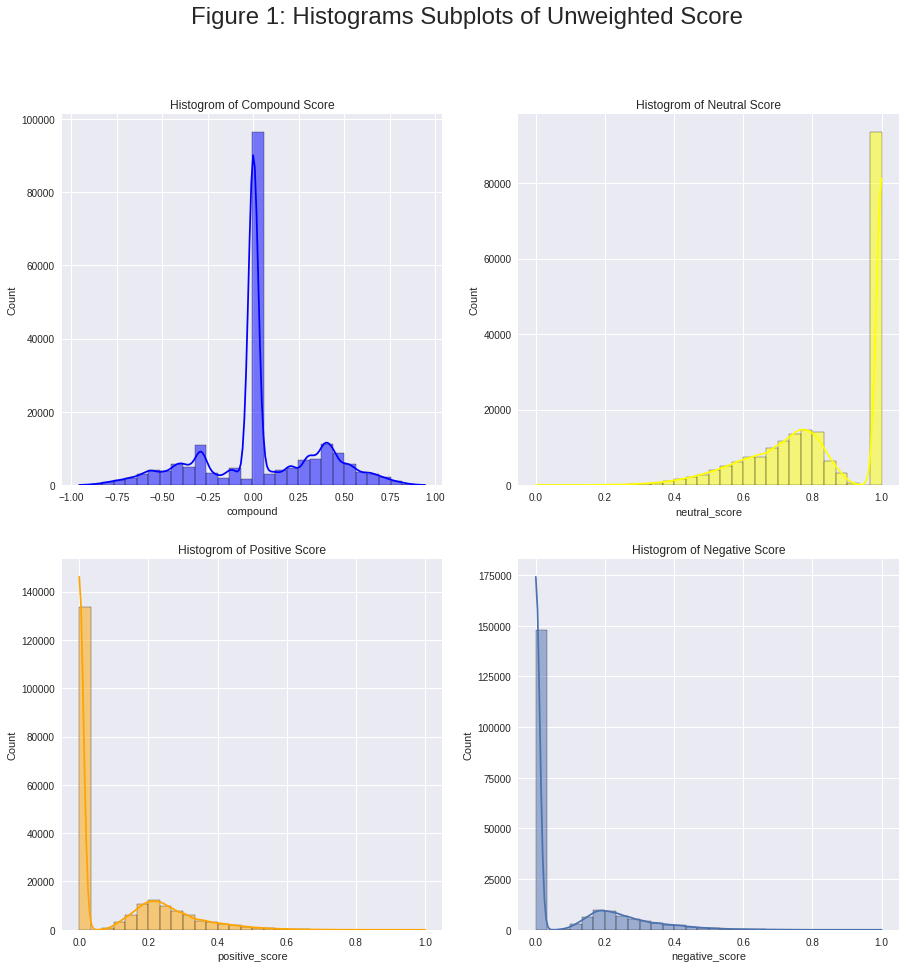

In [292]:
fig, axes = plt.subplots(2,2, figsize = (15 ,15))
fig.suptitle('Figure 1: Histograms Subplots of Unweighted Score',fontsize = 24)


axes[0,0].set_title('Histogrom of Compound Score')
axes[0,1].set_title('Histogrom of Neutral Score')
axes[1,0].set_title('Histogrom of Positive Score')
axes[1,1].set_title('Histogrom of Negative Score')



sns.histplot(News_Headlines, x = 'compound', bins = 30, ax = axes[0,0],
            color = 'Blue',kde = True)

sns.histplot(News_Headlines, x = 'neutral_score', bins = 30, ax = axes[0,1],
             color = 'yellow',kde = True)

sns.histplot(News_Headlines, x = 'positive_score', bins = 30, ax = axes[1,0],
             color = 'Orange',kde = True)

sns.histplot(News_Headlines, x = 'negative_score', bins = 30, ax = axes[1,1],
             kde = True)



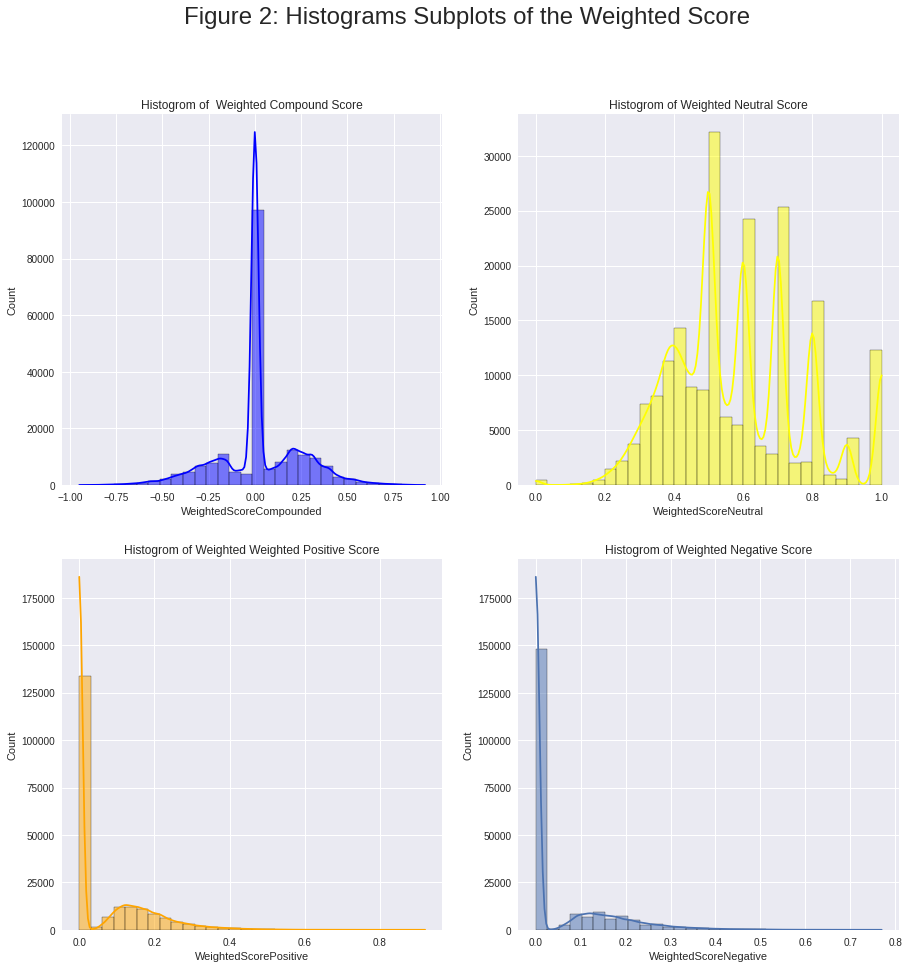

In [293]:
fig, axes = plt.subplots(2,2, figsize = (15 ,15))
fig.suptitle('Figure 2: Histograms Subplots of the Weighted Score',fontsize = 24)


axes[0,0].set_title('Histogrom of  Weighted Compound Score')
axes[0,1].set_title('Histogrom of Weighted Neutral Score')
axes[1,0].set_title('Histogrom of Weighted Weighted Positive Score')
axes[1,1].set_title('Histogrom of Weighted Negative Score')



sns.histplot(News_Headlines, x = 'WeightedScoreCompounded', bins = 30, ax = axes[0,0],
            color = 'Blue',kde = True)

sns.histplot(News_Headlines, x = 'WeightedScoreNeutral', bins = 30, ax = axes[0,1],
             color = 'yellow',kde = True)

sns.histplot(News_Headlines, x = 'WeightedScorePositive', bins = 30, ax = axes[1,0],
             color = 'Orange',kde = True)

sns.histplot(News_Headlines, x = 'WeightedScoreNegative', bins = 30, ax = axes[1,1],
             kde = True)

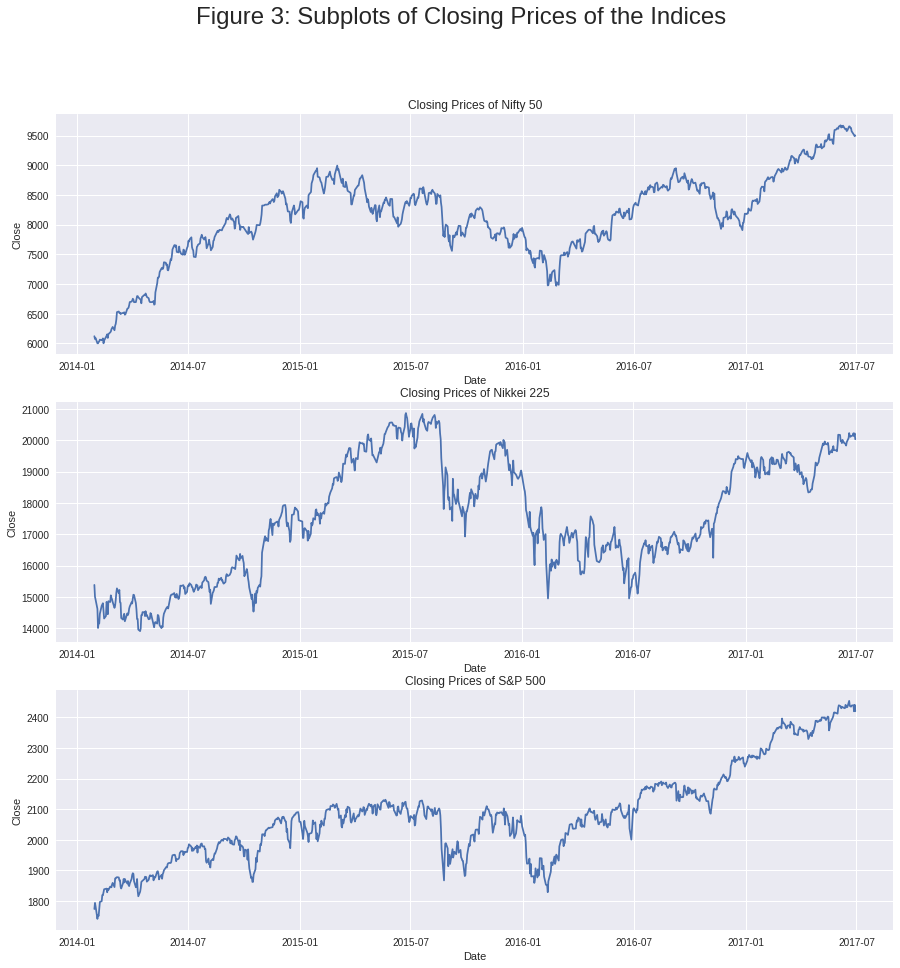

In [294]:
fig, axes = plt.subplots(3,1, figsize = (15 ,15))
fig.suptitle('Figure 3: Subplots of Closing Prices of the Indices',fontsize = 24)


axes[0,].set_title('Closing Prices of Nifty 50')
axes[1,].set_title('Closing Prices of Nikkei 225')
axes[2,].set_title('Closing Prices of S&P 500')


sns.lineplot(x = 'Date' , y  = 'Close', data = nifty50Data, ax = axes[0,])

sns.lineplot(x = 'Date' , y  = 'Close', data = Nikkei225, ax = axes[1,])

sns.lineplot(x = 'Date' , y  = 'Close', data = SP500, ax = axes[2,])

### Final Preprocessing

#### News Headlines

In [295]:
News_Headlines.head()

Date_Time  compound  negative_score  neutral_score  \
0 2017-06-30 19:08:00    0.4926            0.00          0.814   
1 2017-06-30 18:57:00    0.0000            0.00          1.000   
2 2017-06-30 18:57:00    0.0000            0.00          1.000   
3 2017-06-30 18:57:00    0.2960            0.00          0.855   
4 2017-06-30 18:55:00   -0.0772            0.23          0.559   

   positive_score  Weight  WeightedScoreCompounded  WeightedScoreNeutral  \
0           0.186     1.0                     0.49                  0.81   
1           0.000     1.0                     0.00                  1.00   
2           0.000     1.0                     0.00                  1.00   
3           0.145     1.0                     0.30                  0.86   
4           0.211     1.0                    -0.08                  0.56   

   WeightedScorePositive  WeightedScoreNegative  
0                   0.19                   0.00  
1                   0.00                   0.00  
2                   0.00                   0.00  
3                   0.14                   0.00  
4                   0.21                   0.23

In [296]:
News_Headlines = News_Headlines.groupby([News_Headlines['Date_Time'].dt.date]).sum()

In [297]:
News_Headlines = News_Headlines.round(2)

In [298]:
News_Headlines.drop(columns = ['compound', 'negative_score', 'neutral_score', 'positive_score', 'Weight'], inplace=True)

In [299]:
News_Headlines.head()

WeightedScoreCompounded  WeightedScoreNeutral  \
Date_Time                                                   
2014-04-14                    -0.22                  0.75   
2014-04-16                    -0.32                  8.51   
2014-04-17                     2.42                 22.00   
2014-04-18                     6.17                 66.27   
2014-04-19                    -0.26                 71.55   

            WeightedScorePositive  WeightedScoreNegative  
Date_Time                                                 
2014-04-14                   0.00                   0.15  
2014-04-16                   0.78                   1.11  
2014-04-17                   2.64                   1.17  
2014-04-18                   9.15                   4.40  
2014-04-19                   7.70                   7.94

#### Stock Indices


In [300]:
nifty50Data = nifty50Data[['IndiaGap']]

In [301]:
Nikkei225 = Nikkei225[['JapGap']]

In [302]:
SP500 = SP500[['USMove']]

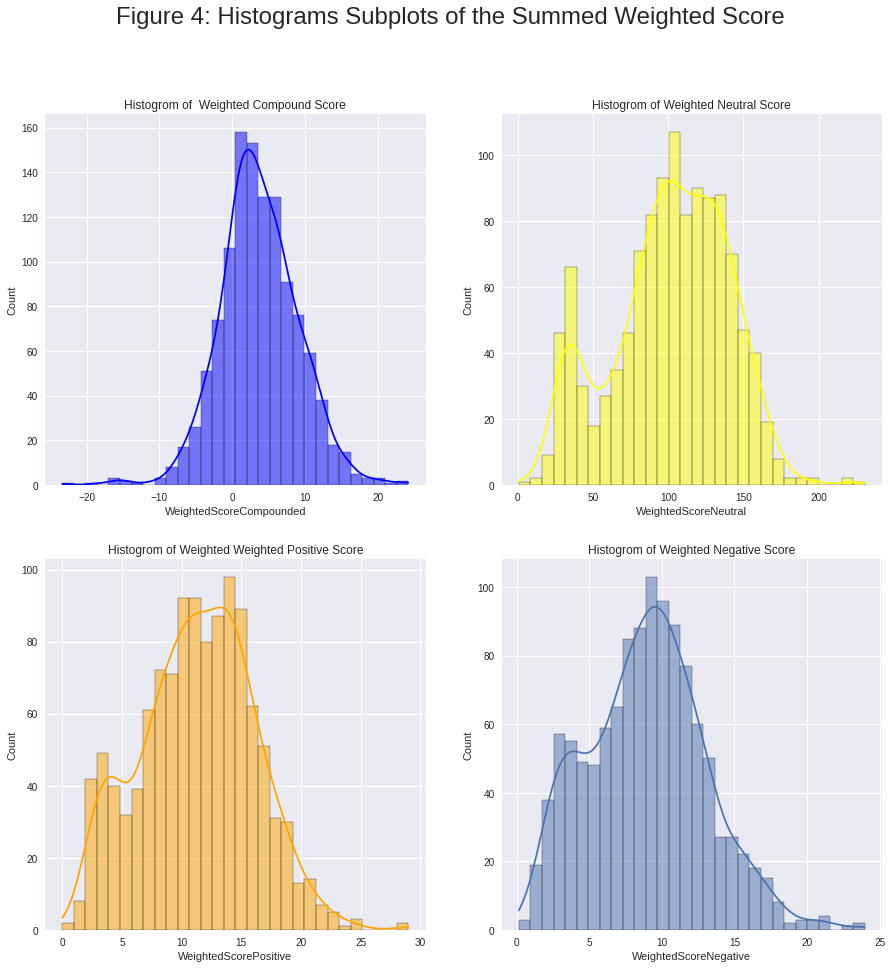

In [303]:
fig, axes = plt.subplots(2,2, figsize = (15 ,15))
fig.suptitle('Figure 4: Histograms Subplots of the Summed Weighted Score',fontsize = 24)


axes[0,0].set_title('Histogrom of  Weighted Compound Score')
axes[0,1].set_title('Histogrom of Weighted Neutral Score')
axes[1,0].set_title('Histogrom of Weighted Weighted Positive Score')
axes[1,1].set_title('Histogrom of Weighted Negative Score')



sns.histplot(News_Headlines, x = 'WeightedScoreCompounded', bins = 30, ax = axes[0,0],
            color = 'Blue',kde = True)

sns.histplot(News_Headlines, x = 'WeightedScoreNeutral', bins = 30, ax = axes[0,1],
             color = 'yellow',kde = True)

sns.histplot(News_Headlines, x = 'WeightedScorePositive', bins = 30, ax = axes[1,0],
             color = 'Orange',kde = True)

sns.histplot(News_Headlines, x = 'WeightedScoreNegative', bins = 30, ax = axes[1,1],
             kde = True)

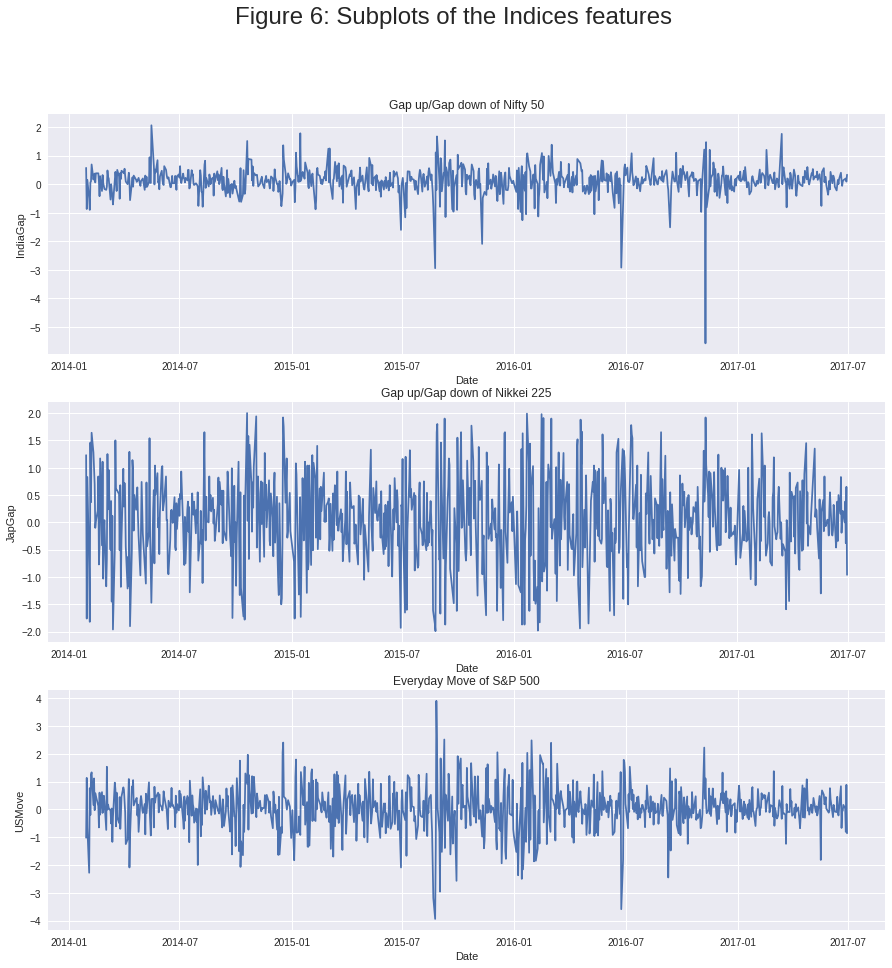

In [304]:
fig, axes = plt.subplots(3,1, figsize = (15 ,15))
fig.suptitle('Figure 6: Subplots of the Indices features',fontsize = 24)


axes[0,].set_title('Gap up/Gap down of Nifty 50')
axes[1,].set_title('Gap up/Gap down of Nikkei 225')
axes[2,].set_title('Everyday Move of S&P 500')


sns.lineplot(x = 'Date' , y  = 'IndiaGap', data = nifty50Data, ax = axes[0,])

sns.lineplot(x = 'Date' , y  = 'JapGap', data = Nikkei225, ax = axes[1,])

sns.lineplot(x = 'Date' , y  = 'USMove', data = SP500, ax = axes[2,])

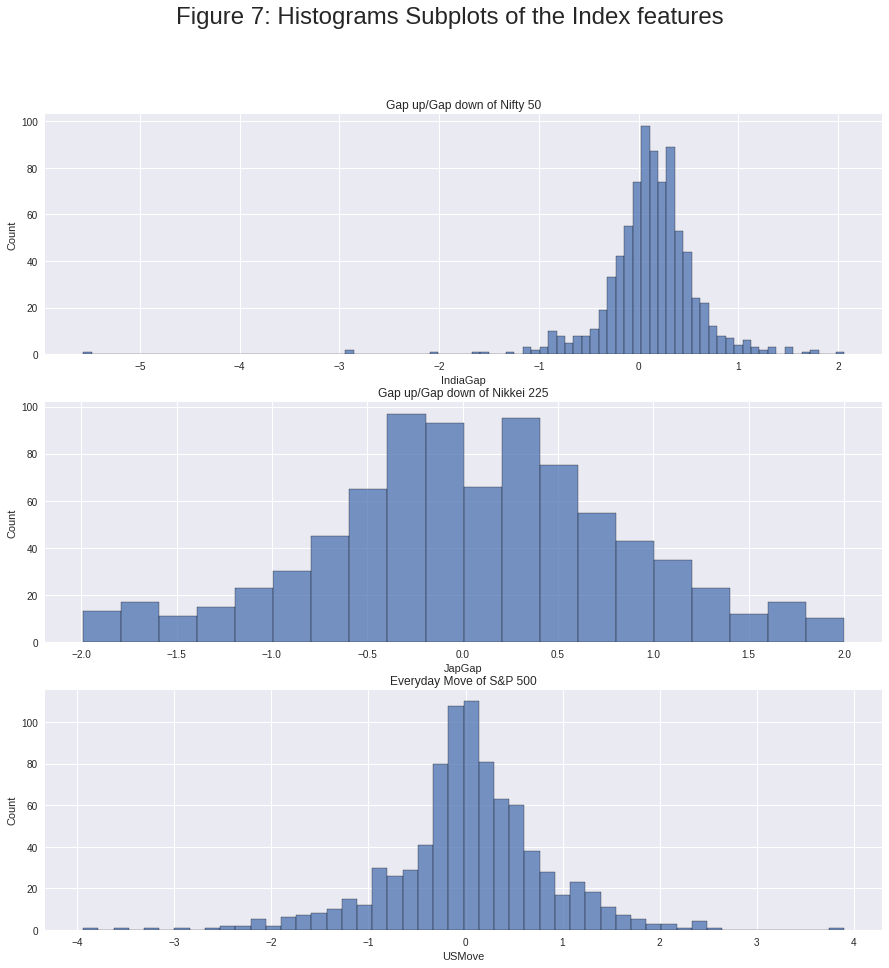

In [305]:
fig, axes = plt.subplots(3,1, figsize = (15 ,15))
fig.suptitle('Figure 7: Histograms Subplots of the Index features',fontsize = 24)


axes[0,].set_title('Gap up/Gap down of Nifty 50')
axes[1,].set_title('Gap up/Gap down of Nikkei 225')
axes[2,].set_title('Everyday Move of S&P 500')


sns.histplot(x = 'IndiaGap', data = nifty50Data, ax = axes[0,])

sns.histplot(x = 'JapGap', data = Nikkei225, ax = axes[1,])

sns.histplot(x = 'USMove', data = SP500, ax = axes[2,])

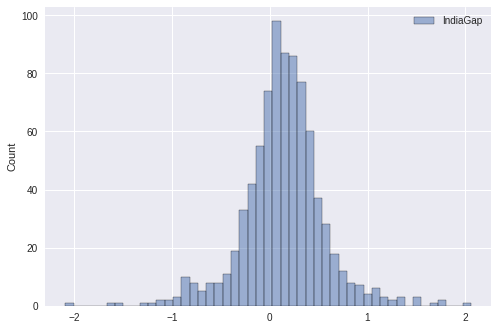

In [306]:
sns.histplot(nifty50Data[(nifty50Data['IndiaGap'] > -2.5)])

In [307]:
nifty50Data = nifty50Data[(nifty50Data['IndiaGap'] > -2.5)]

In [308]:
SP500 = SP500.shift(1)

In [309]:
SP500.dropna(inplace = True)

Merging all Index dataframes into a single dataframe

In [310]:
nifty50Data.reset_index(inplace=True)
Nikkei225.reset_index(inplace=True)
SP500.reset_index(inplace=True)

In [311]:
finalIndex = pd.merge(pd.merge(nifty50Data,Nikkei225,on='Date'),SP500,on='Date')

In [312]:
finalIndex.Date = finalIndex.Date.dt.date

In [313]:
finalIndex.head()

Date  IndiaGap  JapGap  USMove
0  2014-01-30     -0.87   -1.76   -1.02
1  2014-01-31      0.15    0.83    1.13
2  2014-02-03     -0.50   -0.84   -0.65
3  2014-02-04     -0.90   -1.82   -2.28
4  2014-02-05      0.06    1.46    0.76

Merging Index with Newsheadlines

In [314]:
finalData = pd.merge(News_Headlines, finalIndex, left_on='Date_Time', right_on='Date')

In [315]:
IndiaGapCondition = [
    ((-0.25 <= finalData.IndiaGap) & (finalData.IndiaGap <= 0.25)),
  #  ((0.25 < finalData.IndiaGap) & (finalData.IndiaGap <= 0.5)),
  #  ((- 0.25 > finalData.IndiaGap) & (finalData.IndiaGap >= -0.5)),
    ((0.25 < finalData.IndiaGap)),
    ((-0.25 > finalData.IndiaGap))

]

valueInd = ['flat','positive','negative']

In [316]:
finalData['IndGapStatus'] = np.select(IndiaGapCondition,valueInd)

In [317]:
finalData.IndGapStatus.unique()

array(['flat', 'positive', 'negative'], dtype=object)

In [318]:
finalData.head()

WeightedScoreCompounded  WeightedScoreNeutral  WeightedScorePositive  \
0                    -0.32                  8.51                   0.78   
1                     2.42                 22.00                   2.64   
2                    -1.40                 85.55                   7.67   
3                     5.55                114.09                  12.72   
4                     7.39                128.17                  13.64   

   WeightedScoreNegative        Date  IndiaGap  JapGap  USMove IndGapStatus  
0                   1.11  2014-04-16     -0.09    0.93    0.68         flat  
1                   1.17  2014-04-17      0.30   -0.15    1.05     positive  
2                   8.47  2014-04-21      0.15    0.23    0.14         flat  
3                   9.56  2014-04-22      0.08    0.51    0.38         flat  
4                   9.89  2014-04-23      0.12    0.64    0.41         flat

In [319]:
h = pd.DataFrame(finalData.groupby('IndGapStatus', as_index=False)['WeightedScoreCompounded'].mean())
i = pd.DataFrame(finalData.groupby('IndGapStatus', as_index=False)['WeightedScoreNegative'].mean())
j = pd.DataFrame(finalData.groupby('IndGapStatus', as_index=False)['WeightedScorePositive'].mean())
k = pd.DataFrame(finalData.groupby('IndGapStatus', as_index=False)['WeightedScoreNeutral'].mean())
l = pd.DataFrame(finalData.groupby('IndGapStatus',as_index=False)['USMove'].mean())
m = pd.DataFrame(finalData.groupby('IndGapStatus', as_index=False)['JapGap'].mean())

[Text(0, 0, 'flat'), Text(0, 0, 'negative'), Text(0, 0, 'positive')]

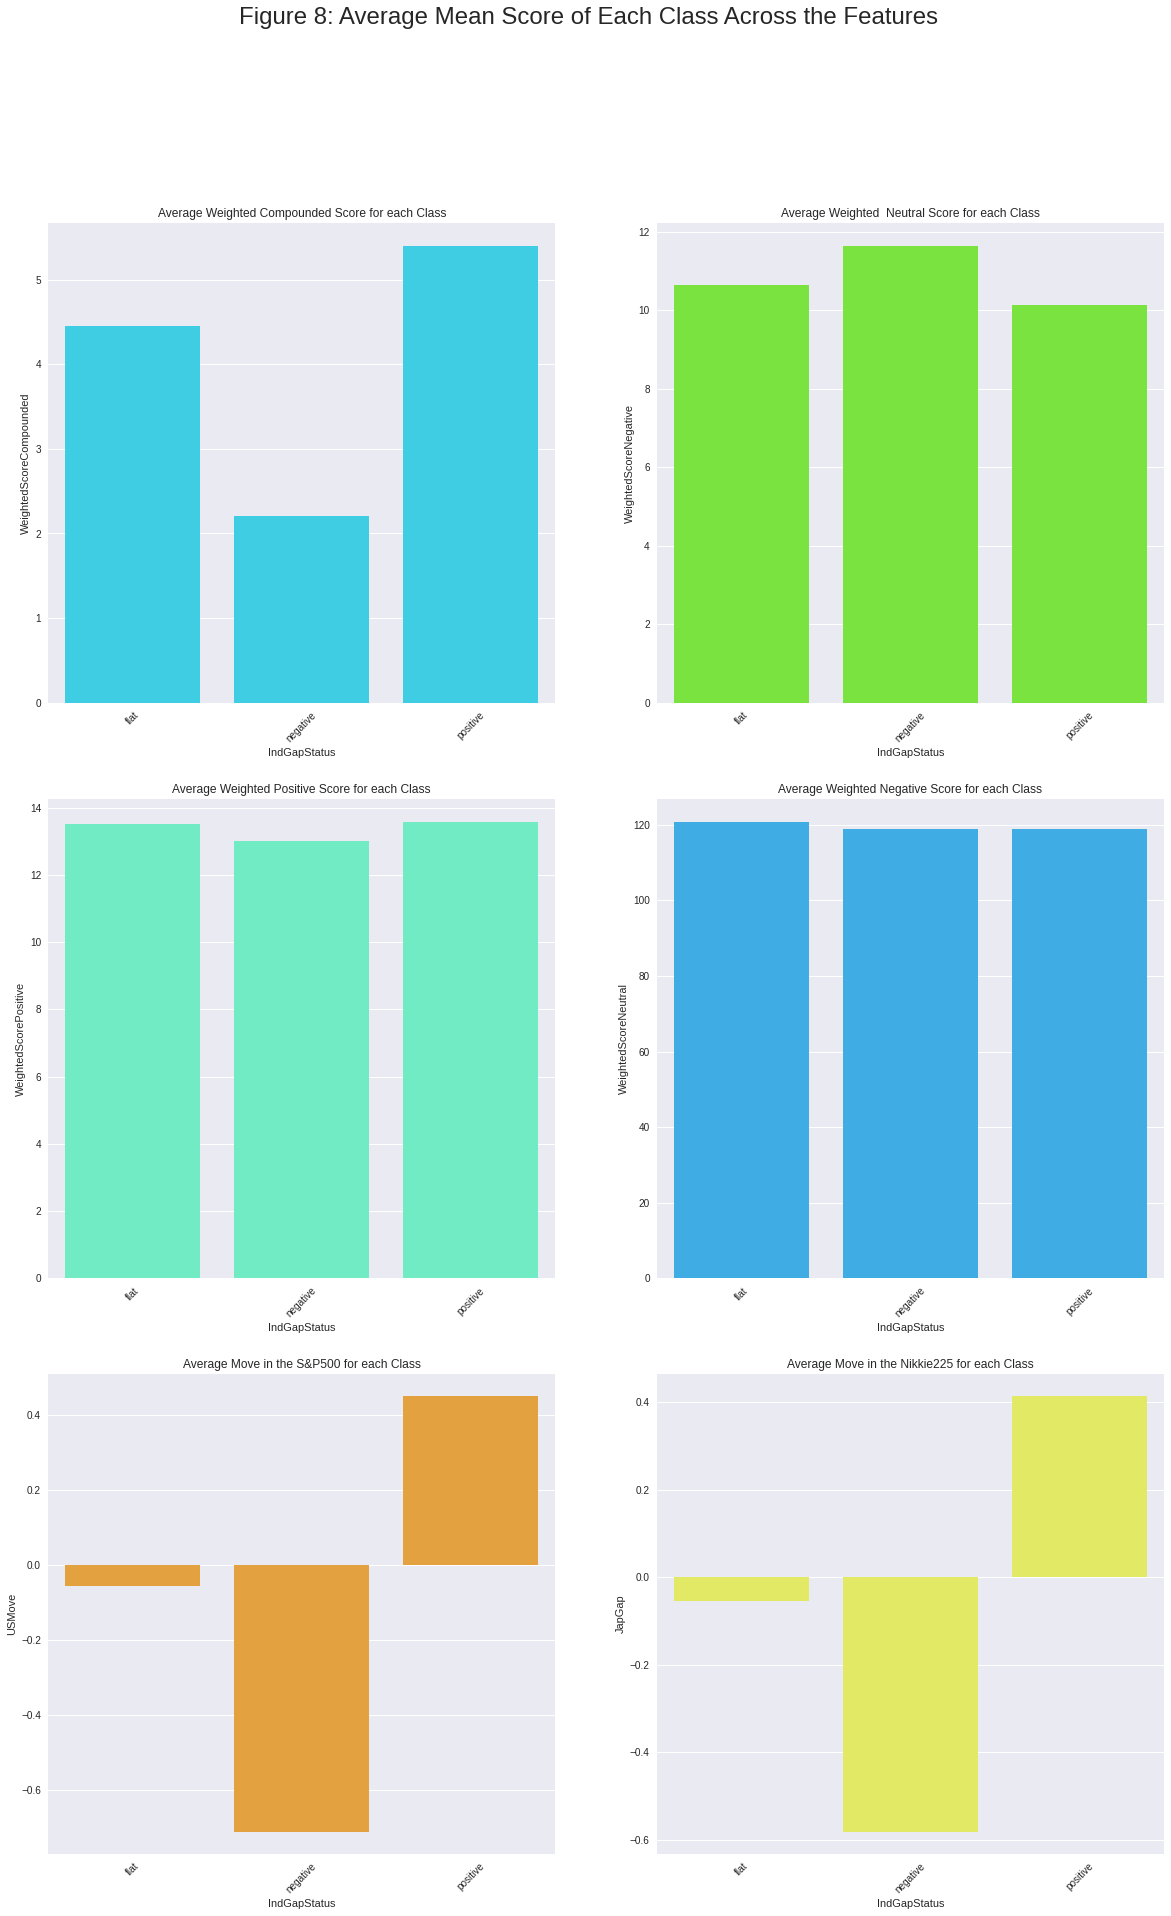

In [320]:
fig, axes = plt.subplots(3,2, figsize = (20 ,30))
fig.suptitle('Figure 8: Average Mean Score of Each Class Across the Features',fontsize = 24)


axes[0,0].set_title('Average Weighted Compounded Score for each Class')
axes[0,1].set_title('Average Weighted  Neutral Score for each Class')
axes[1,0].set_title('Average Weighted Positive Score for each Class')
axes[1,1].set_title('Average Weighted Negative Score for each Class')
axes[2,0].set_title('Average Move in the S&P500 for each Class')
axes[2,1].set_title('Average Move in the Nikkie225 for each Class')


g1 = sns.barplot(data = h, x = 'IndGapStatus', y = 'WeightedScoreCompounded', ax = axes[0,0],
            color = '#23e1ff')


g2 = sns.barplot(data = i, x = 'IndGapStatus', y = 'WeightedScoreNegative', ax = axes[0,1],
            color = '#73ff23')


g3 = sns.barplot(data = j, x = 'IndGapStatus', y = 'WeightedScorePositive', ax = axes[1,0],
            color = '#5dffcb')

g4 = sns.barplot(data = k, x = 'IndGapStatus', y = 'WeightedScoreNeutral', ax = axes[1,1],
            color = '#23b6ff')


g5 = sns.barplot(data = l, x = 'IndGapStatus', y = 'USMove', ax = axes[2,0],
            color = '#ffa823')

g6 = sns.barplot(data = m, x = 'IndGapStatus', y = 'JapGap', ax = axes[2,1],
            color = '#f6ff4f')


g1.set_xticklabels(h['IndGapStatus'].tolist(), rotation = 45)
g2.set_xticklabels(i['IndGapStatus'].tolist(), rotation = 45)
g3.set_xticklabels(j['IndGapStatus'].tolist(), rotation = 45)
g4.set_xticklabels(k['IndGapStatus'].tolist(), rotation = 45)
g5.set_xticklabels(l['IndGapStatus'].tolist(), rotation = 45)
g6.set_xticklabels(m['IndGapStatus'].tolist(), rotation = 45)

In [321]:
finalData.head()

WeightedScoreCompounded  WeightedScoreNeutral  WeightedScorePositive  \
0                    -0.32                  8.51                   0.78   
1                     2.42                 22.00                   2.64   
2                    -1.40                 85.55                   7.67   
3                     5.55                114.09                  12.72   
4                     7.39                128.17                  13.64   

   WeightedScoreNegative        Date  IndiaGap  JapGap  USMove IndGapStatus  
0                   1.11  2014-04-16     -0.09    0.93    0.68         flat  
1                   1.17  2014-04-17      0.30   -0.15    1.05     positive  
2                   8.47  2014-04-21      0.15    0.23    0.14         flat  
3                   9.56  2014-04-22      0.08    0.51    0.38         flat  
4                   9.89  2014-04-23      0.12    0.64    0.41         flat

In [322]:
finalData['Date'] = pd.to_datetime(finalData.Date,format = '%Y-%m-%d') # Converting to datetime format

In [323]:
finalData['Date'] = finalData.Date.dt.strftime('%A')

In [324]:
#, 'WeightedScoreNeutral', 'WeightedScorePositive', 'WeightedScoreNegative'

In [325]:
finalData.drop(columns = ['IndiaGap'], inplace = True)

In [326]:
finalData.IndGapStatus.value_counts()

flat        365
positive    260
negative     85
Name: IndGapStatus, dtype: int64

In [327]:
finalData.Date.value_counts()

Wednesday    152
Tuesday      149
Thursday     144
Friday       143
Monday       122
Name: Date, dtype: int64

### Predictive Modelling

The Data has serious imbalance

In [328]:
X, y = finalData.drop(columns = 'IndGapStatus') , finalData[['IndGapStatus']]
X = pd.get_dummies(X)

In [329]:
labelling = LabelEncoder()
y = labelling.fit_transform(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [330]:
labelling.inverse_transform([0,1,2])

array(['flat', 'negative', 'positive'], dtype=object)

In [331]:
finalData.IndGapStatus.value_counts()

flat        365
positive    260
negative     85
Name: IndGapStatus, dtype: int64

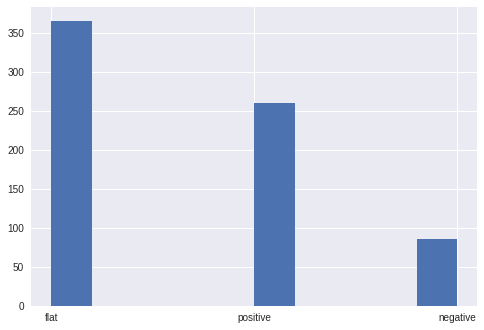

In [332]:
finalData.IndGapStatus.hist()

In [333]:
# transform the dataset

strategy = { 0:365,
             1:365,
             2:365,

}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X, y)

In [334]:
X.shape

(1095, 11)

In [335]:
y.shape

(1095,)

In [336]:
target = pd.Series(y)
target =target.rename('IndiaGapStatus')

In [337]:
cor  = pd.merge(X,target,left_index=True, right_index=True)

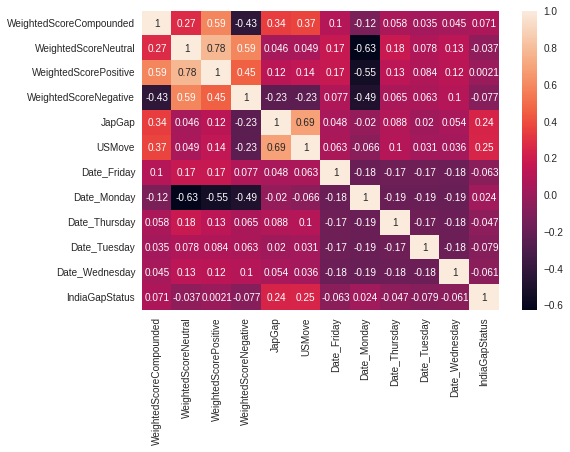

In [338]:
sns.heatmap(cor.corr(), annot = True)

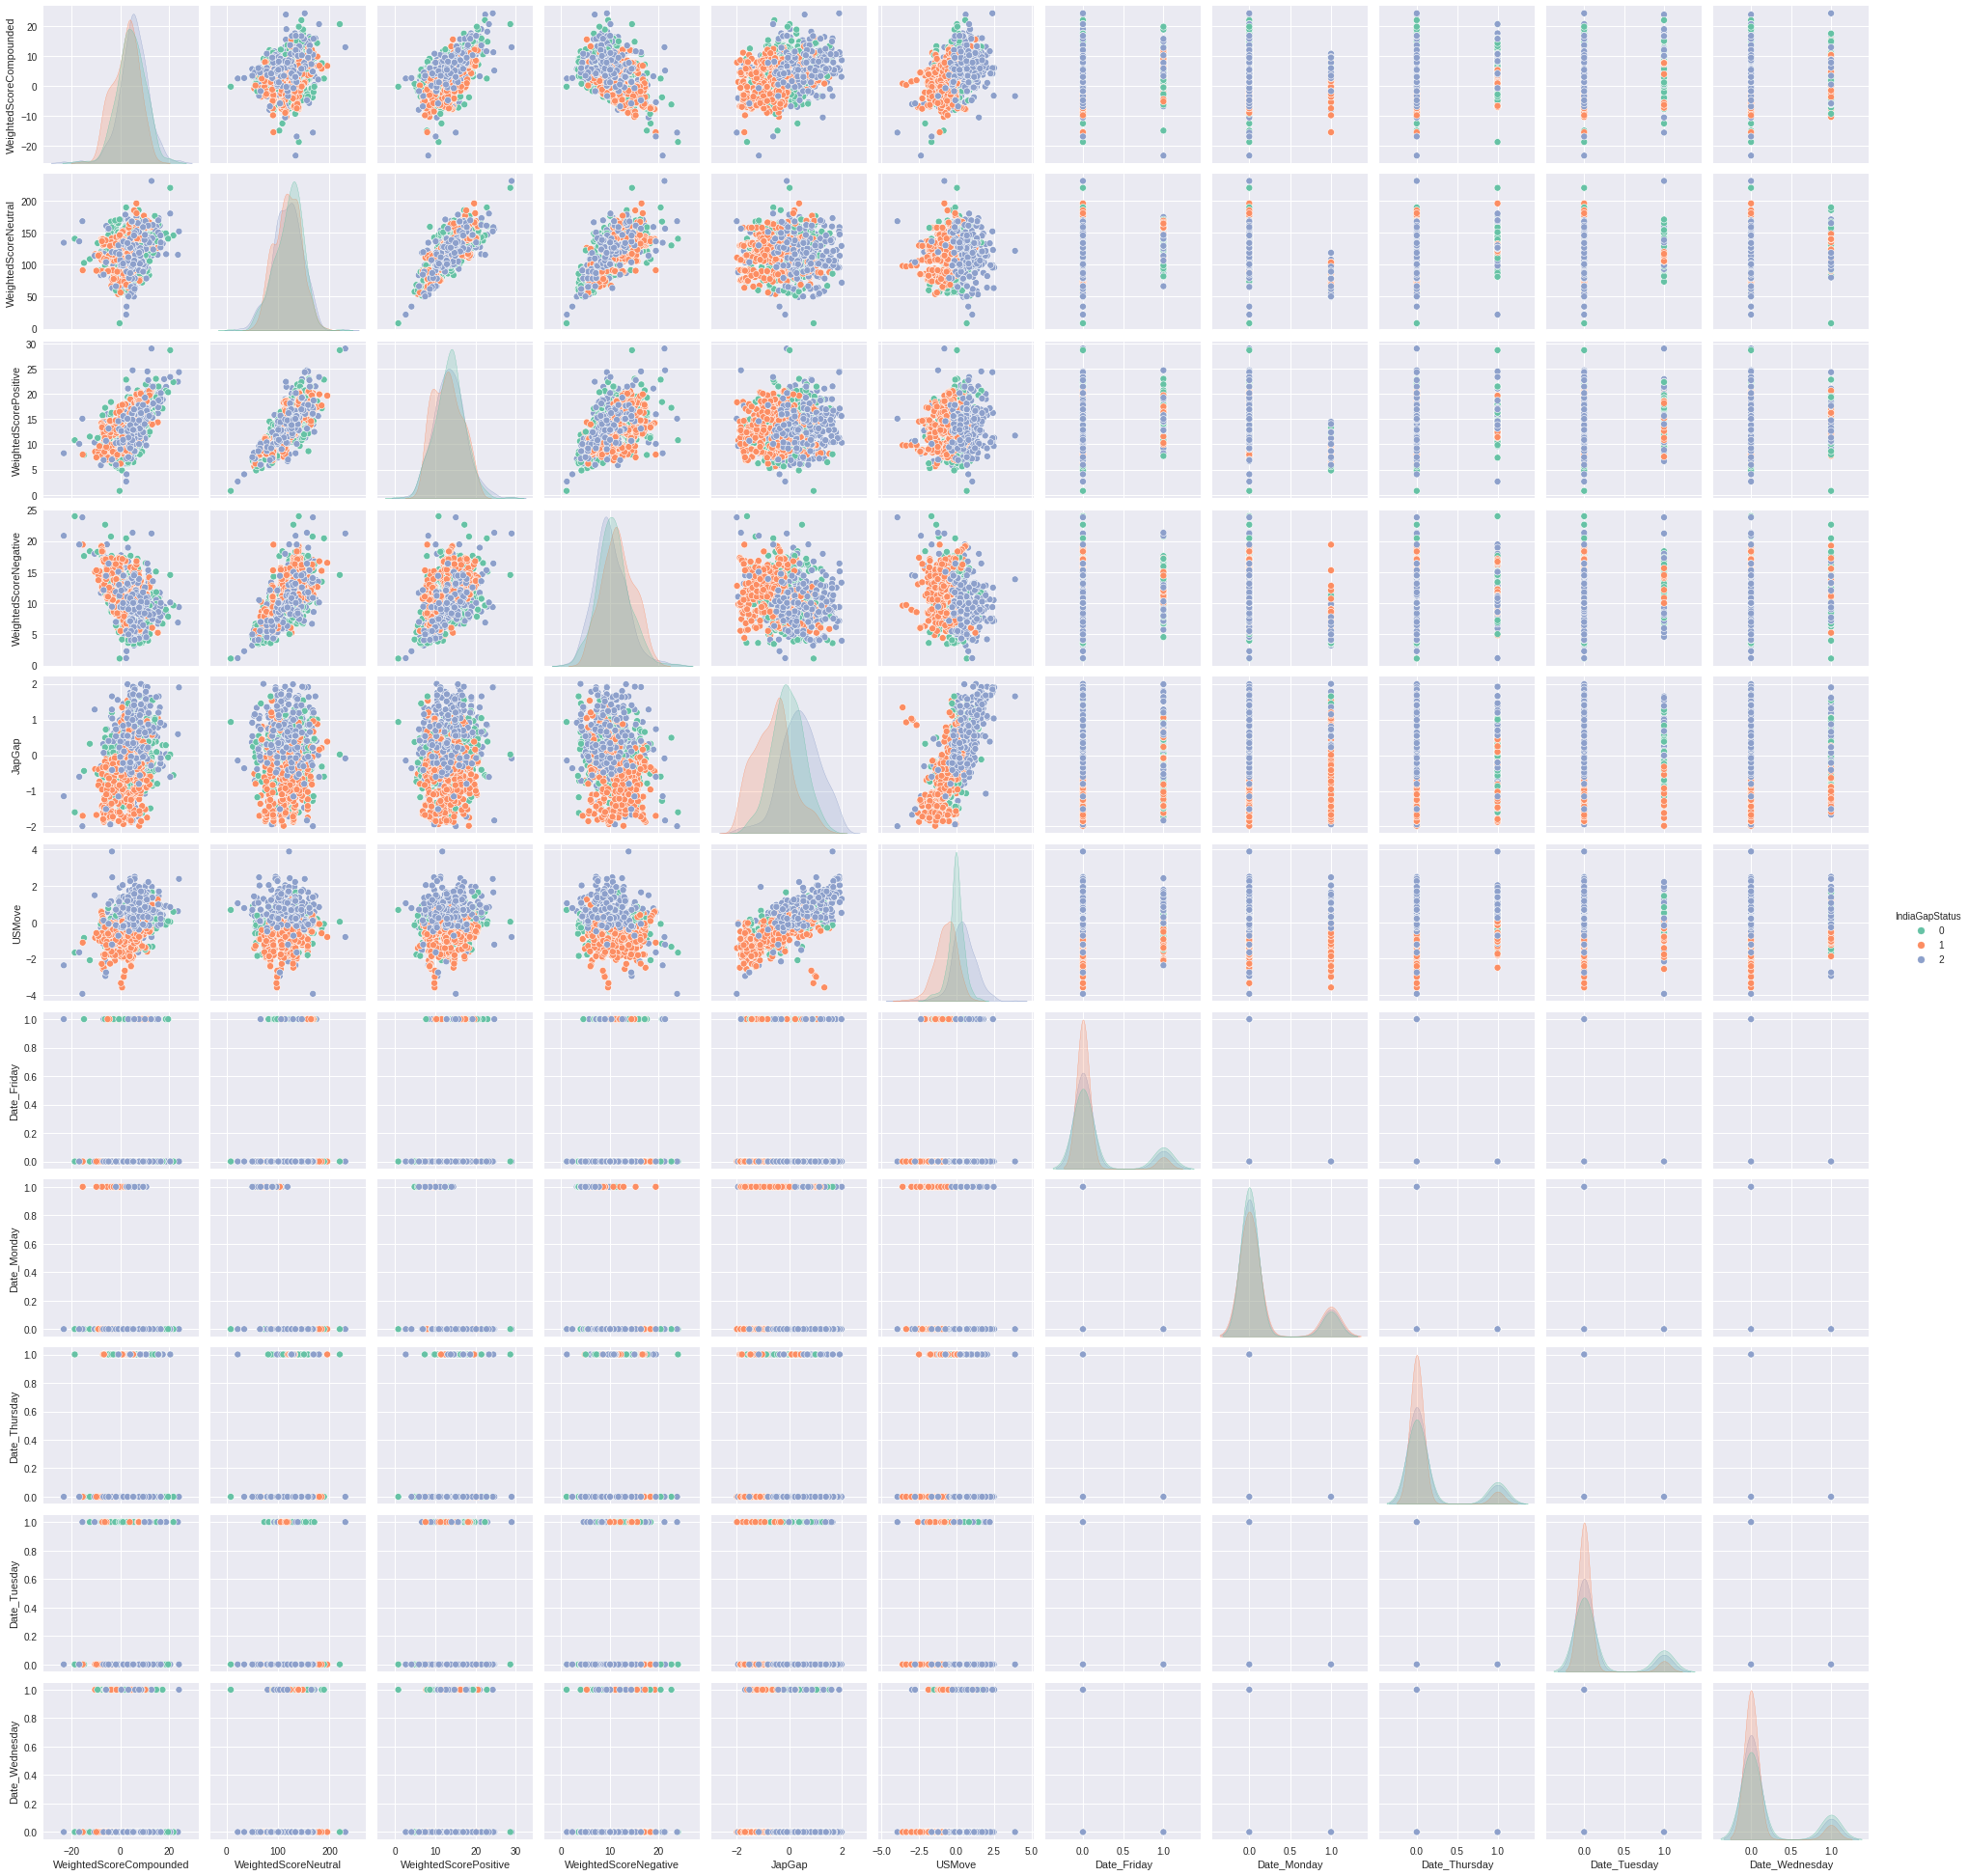

In [339]:
sns.pairplot(cor, hue = 'IndiaGapStatus', palette= 'Set2')

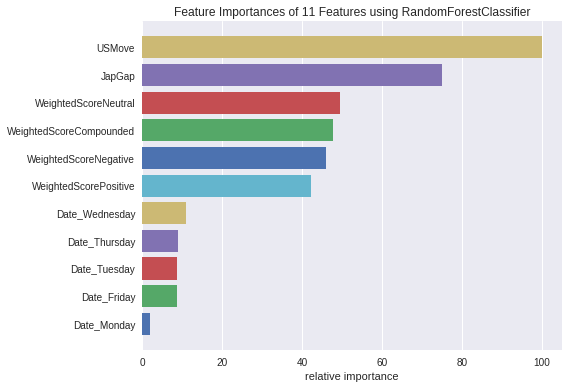

In [340]:
model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()

In [341]:
X.columns.values

array(['WeightedScoreCompounded', 'WeightedScoreNeutral',
       'WeightedScorePositive', 'WeightedScoreNegative', 'JapGap',
       'USMove', 'Date_Friday', 'Date_Monday', 'Date_Thursday',
       'Date_Tuesday', 'Date_Wednesday'], dtype=object)

In [342]:
X.drop(columns= ['Date_Friday','Date_Monday','Date_Thursday','Date_Tuesday', 'Date_Wednesday'], inplace=True)

In [343]:
cor  = pd.merge(X,target,left_index=True, right_index=True)

In [344]:
cor.head()

WeightedScoreCompounded  WeightedScoreNeutral  WeightedScorePositive  \
0                    -0.32                  8.51                   0.78   
1                     2.42                 22.00                   2.64   
2                    -1.40                 85.55                   7.67   
3                     5.55                114.09                  12.72   
4                     7.39                128.17                  13.64   

   WeightedScoreNegative  JapGap  USMove  IndiaGapStatus  
0                   1.11    0.93    0.68               0  
1                   1.17   -0.15    1.05               2  
2                   8.47    0.23    0.14               0  
3                   9.56    0.51    0.38               0  
4                   9.89    0.64    0.41               0

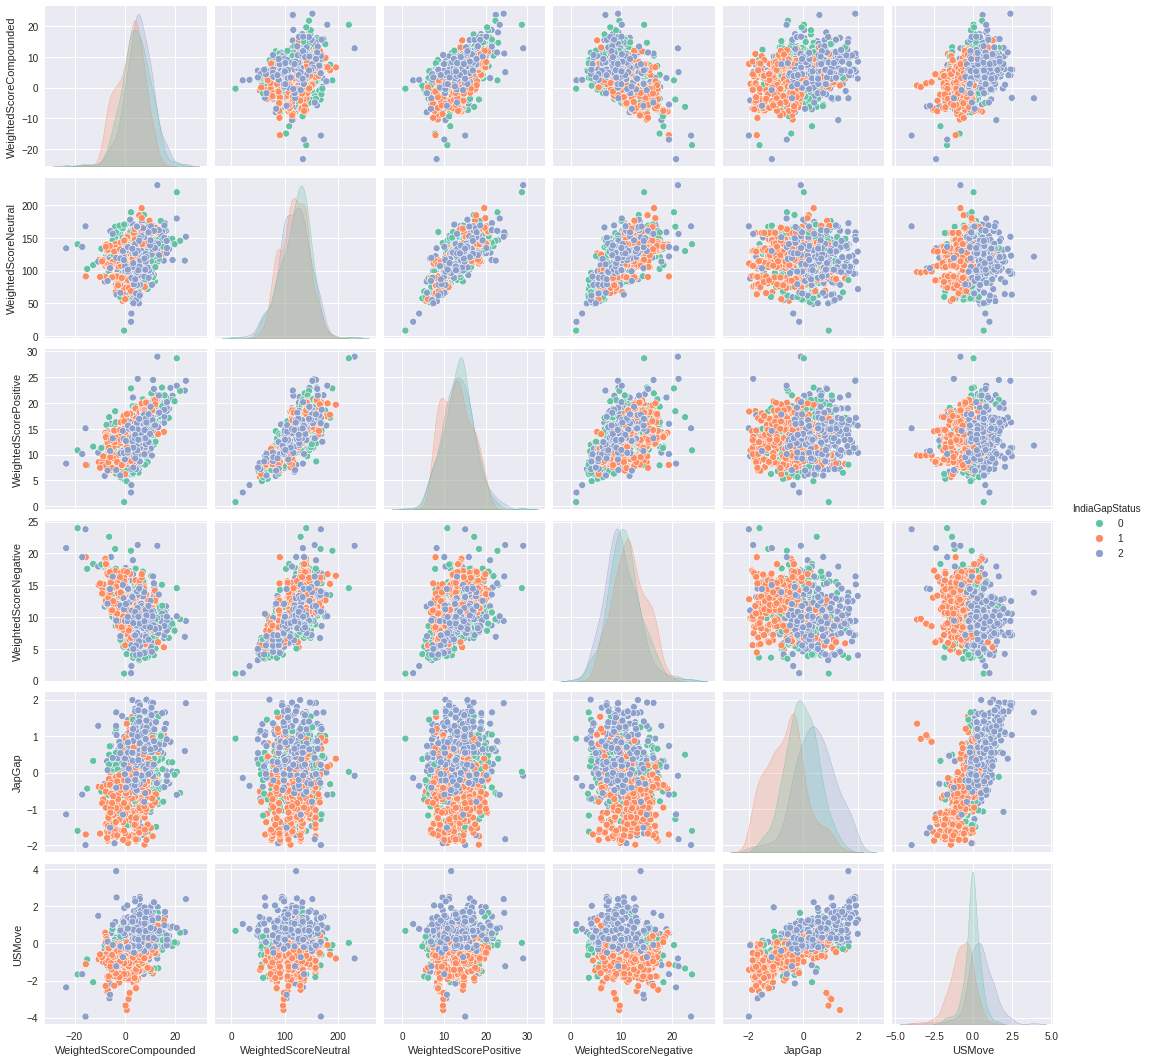

In [345]:
### Draw a Pair Plot

sns.pairplot(cor, hue = 'IndiaGapStatus', palette= 'Set2')

### Prediction Models

In [346]:
from yellowbrick.model_selection import ValidationCurve


In [347]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,stratify=y,random_state=50)

In [348]:
# K Nearest Nieghbors

In [349]:
clfKnn = KNeighborsClassifier()

In [350]:
clfKnn.fit(X_train, y_train)

KNeighborsClassifier()

In [351]:
y_predicted = clfKnn.predict(X_test)

In [352]:
cm = confusion_matrix(y_test, y_predicted)

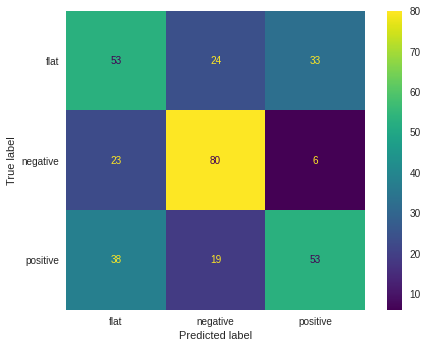

In [353]:
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfKnn.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


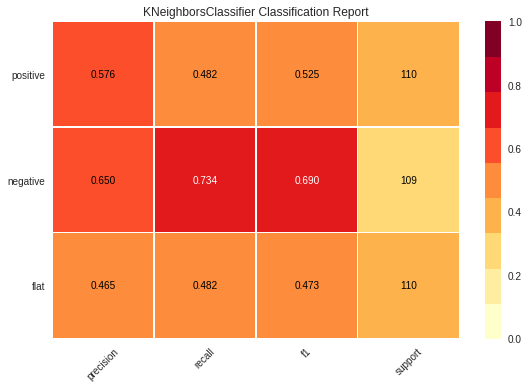

In [354]:
visualizer = ClassificationReport(clfKnn, classes = labelling.inverse_transform(clfKnn.classes_),  support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()   

In [355]:
clfKnn.score(X_train,y_train)

0.6984334203655352

In [356]:
accuracy_score(y_test, y_predicted)

0.5653495440729484

In [357]:
clfKnn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

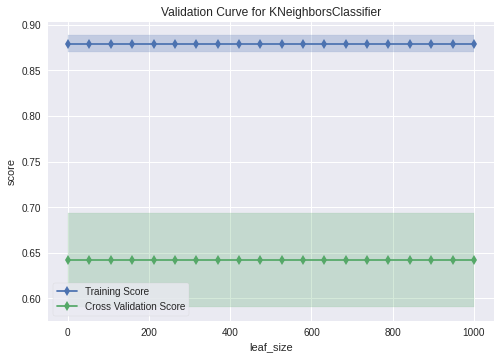

In [358]:
param_range = np.linspace(start = 1, stop = 1000, num = 20)

oz = ValidationCurve(
    KNeighborsClassifier(n_neighbors= 2, p = 1 ), param_name="leaf_size",
    param_range=param_range, cv=10, scoring="accuracy",
)

oz.fit(X, y)
oz.show()

In [359]:
HyperparametersKNN={"n_neighbors": [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)],
                    "weights" : ['uniform', 'distance'],
                    "algorithm" : ['ball_tree', 'kd_tree', 'brute'],
                    'p': [1,2]
                    }

In [360]:
clfKnnHy = RandomizedSearchCV(clfKnn,HyperparametersKNN,cv=5, n_iter=50)


In [361]:
clfKnnHy.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=50,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'n_neighbors': [1, 2, 3, 4, 5],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']})

In [362]:
y_predictedHy = clfKnnHy.predict(X_test)

In [363]:
cm = confusion_matrix(y_test, y_predictedHy)

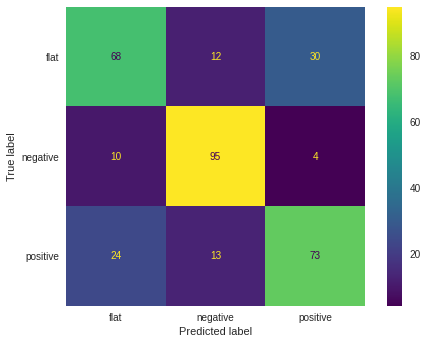

In [364]:
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfKnn.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


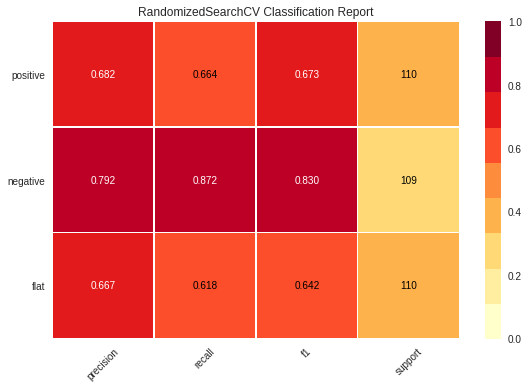

In [365]:
visualizer = ClassificationReport(clfKnnHy, classes = labelling.inverse_transform(clfKnn.classes_),  support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show() 

In [366]:
clfKnnHy.score(X_train,y_train)

1.0

In [467]:
accuracyKNN = accuracy_score(y_test, y_predictedHy)
accuracyKNN

0.7173252279635258

In [368]:
Y_prob = clfKnnHy.predict_proba(X_test)
aucScoreKNN = roc_auc_score(y_test, Y_prob, multi_class = "ovo")
aucScoreKNN

0.7883444537114261

In [468]:
f1KNN = f1_score(y_test, y_predictedHy, average= 'weighted')
f1KNN

0.7143219925483837

In [ ]:
metricsData

In [369]:
# Decision Tree 

In [370]:
clfDT = DecisionTreeClassifier(random_state=0)

In [371]:
clfDT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [372]:
y_pred = clfDT.predict(X_test)

In [373]:
cm = confusion_matrix(y_test, y_pred)

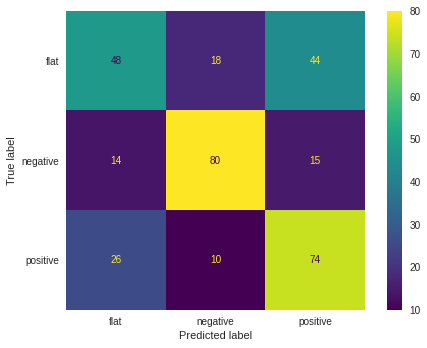

In [374]:
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfDT.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


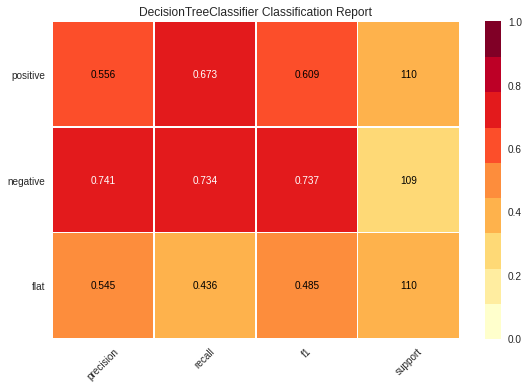

In [375]:
visualizer = ClassificationReport(clfDT, classes = labelling.inverse_transform(clfDT.classes_),  support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show() 

In [376]:
clfDT.score(X_train, y_train)

1.0

In [377]:
accuracy_score(y_test, y_pred)

0.6139817629179332

In [378]:
clfDT.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

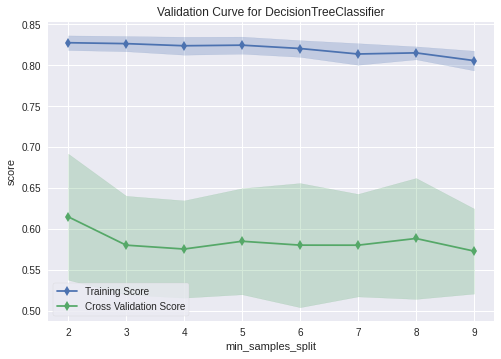

In [379]:
param_range = np.arange(0,10,1)

viz = ValidationCurve(
    DecisionTreeClassifier(max_depth = 15, ccp_alpha = 0,
                           min_samples_leaf = 2, 
                           max_leaf_nodes = 140,
                           min_weight_fraction_leaf = 0,
                           max_features=1, 
                            
                           )
    ,param_name="min_samples_split",
    param_range=param_range, cv=20, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

In [380]:
HyperparametersDT={'ccp_alpha': [0,0.2],
                    "splitter":["best","random"],
                    "max_depth" : [140, 150, None],
                    "min_samples_leaf":[1,2],
                    "min_weight_fraction_leaf":[0,0.5],
                    "min_samples_split": [2,3,4],
                    "max_leaf_nodes" : [140,150],
                    "max_features":["auto", "sqrt", "log2", None],
                    "class_weight" : ['balanced', None],
                    "criterion" : ['gini', 'entropy'],
                   "max_features": [1, None],
                   "min_samples_split": [3,4, 2]}

In [381]:
clfDTHy = RandomizedSearchCV(clfDT,HyperparametersDT,cv=10, n_iter=50)

In [382]:
clfDTHy.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=50,
                   param_distributions={'ccp_alpha': [0, 0.2],
                                        'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [140, 150, None],
                                        'max_features': [1, None],
                                        'max_leaf_nodes': [140, 150],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [3, 4, 2],
                                        'min_weight_fraction_leaf': [0, 0.5],
                                        'splitter': ['best', 'random']})

In [383]:
y_predhy = clfDTHy.predict(X_test)

In [384]:
clfDTHy.score(X_train, y_train)

0.9216710182767625

In [470]:
accuracyDT = clfDTHy.score(X_test,y_test)
accuracyDT

0.5957446808510638

In [386]:
clfDTHy.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced', max_depth=150,
                       max_leaf_nodes=140, min_samples_leaf=2,
                       min_samples_split=3, min_weight_fraction_leaf=0,
                       random_state=0)

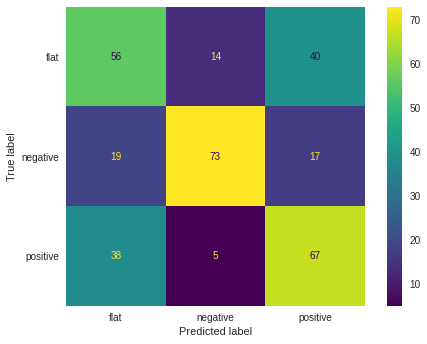

In [387]:
cm = confusion_matrix(y_test, y_predhy)
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfDTHy.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


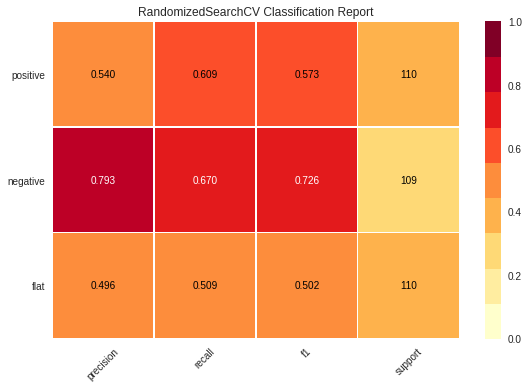

In [388]:
visualizer = ClassificationReport(clfDTHy, classes = labelling.inverse_transform(clfDT.classes_),  support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show() 

In [389]:
Y_prob = clfDTHy.predict_proba(X_test)
aucScoreDT = roc_auc_score(y_test, Y_prob, multi_class = "ovo")
aucScoreDT

0.6787965349912807

In [477]:
f1DT = f1_score(y_test, y_predhy, average= 'weighted')
f1DT

0.600037140170174

In [390]:
# Random Forest

In [391]:
clfRF = RandomForestClassifier(random_state=0)

In [392]:
clfRF.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [393]:
y_predRF = clfRF.predict(X_test)

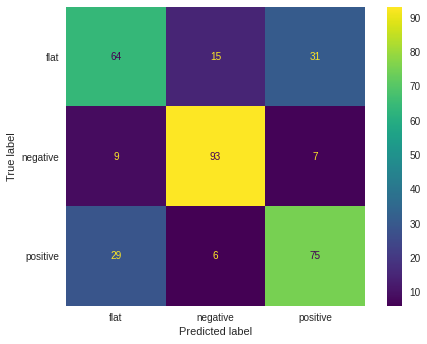

In [394]:
cm = confusion_matrix(y_test, y_predRF)
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfRF.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


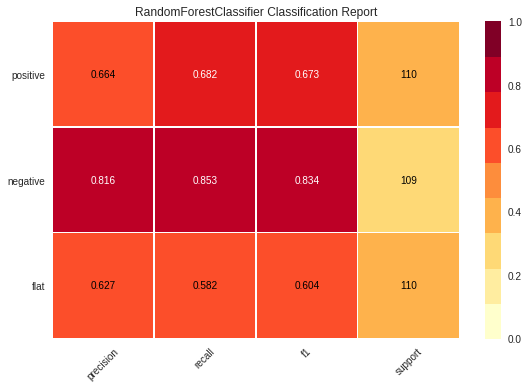

In [395]:
visualizer = ClassificationReport(clfRF, classes = labelling.inverse_transform(clfRF.classes_),  support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()

In [396]:
clfRF.score(X_train,y_train)

1.0

In [397]:
clfRF.score(X_test,y_test)

0.7051671732522796

In [398]:
clfRF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

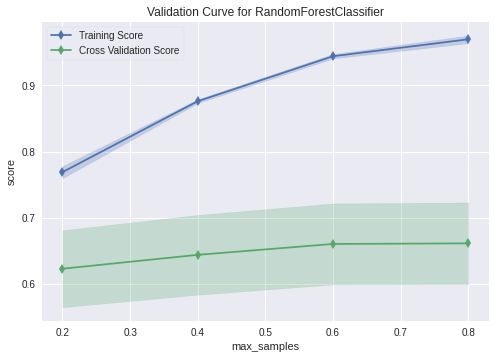

In [399]:
param_range = np.arange(0, 1.0, 0.2)

viz = ValidationCurve(
    RandomForestClassifier(
        n_estimators = 500, ccp_alpha = 0, max_depth = 21,
                           min_samples_split = 2,
                           min_samples_leaf = 2,min_weight_fraction_leaf=0,
                           max_samples = 1,
                           )
    ,param_name="max_samples",
    param_range=param_range, cv=5, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

In [400]:
HyperparametersRf = { 'ccp_alpha': [0,0.1],
                      'n_estimators': [200,500, 1000],
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'max_depth': [20,21,23,50, None],
                      'min_samples_split': [2,4],
                      'min_samples_leaf': [2, 3],
                      'bootstrap': [True],
                      'criterion': ['entropy','gini'],
                     'max_leaf_nodes': [None, 600],
                     "max_samples" :[0.8,1, None]
                     
}

In [401]:
clfRFHy = RandomizedSearchCV(clfRF ,HyperparametersRf ,cv = 5, n_iter = 5)
clfRFHy.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=5,
                   param_distributions={'bootstrap': [True],
                                        'ccp_alpha': [0, 0.1],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [20, 21, 23, 50, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [None, 600],
                                        'max_samples': [0.8, 1, None],
                                        'min_samples_leaf': [2, 3],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [200, 500, 1000]})

In [402]:
y_predRFHy = clfRFHy.predict(X_test)

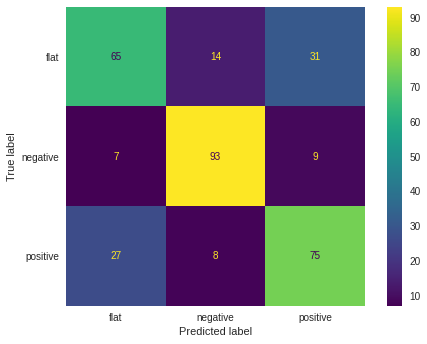

In [403]:
cm = confusion_matrix(y_test, y_predRFHy)
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfRFHy.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


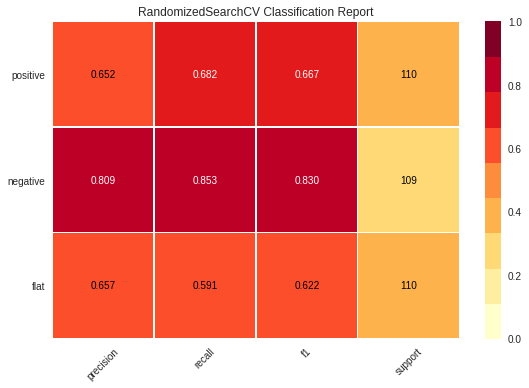

In [404]:
visualizer = ClassificationReport(clfRFHy, classes = labelling.inverse_transform(clfRFHy.classes_),  support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()

In [405]:
clfRFHy.score(X_train, y_train)

0.9869451697127938

In [472]:
accuracyRF = clfRFHy.score(X_test,y_test)
accuracyRF

0.7082066869300911

In [407]:
clfRFHy.best_params_

{'bootstrap': True,
 'ccp_alpha': 0,
 'criterion': 'entropy',
 'max_depth': 21,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [408]:
Y_prob = clfRFHy.predict_proba(X_test)
aucScoreRF = roc_auc_score(y_test, Y_prob, multi_class = "ovo")
aucScoreRF

0.85463189021154

In [476]:
f1RF = f1_score(y_test, y_predRFHy, average= 'weighted')
f1RF

0.7059675213870542

In [409]:
#XGBoost

In [410]:
clfXGB = GradientBoostingClassifier()

In [411]:
clfXGB.fit(X_train, y_train)

GradientBoostingClassifier()

In [412]:
y_predXGB = clfXGB.predict(X_test)

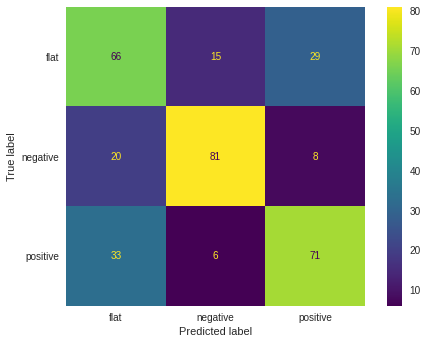

In [413]:
cm = confusion_matrix(y_test, y_predXGB)
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfXGB.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


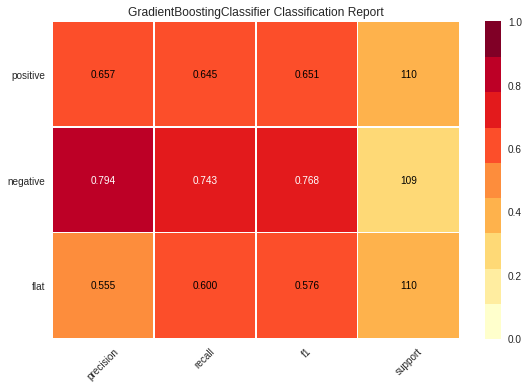

In [414]:
visualizer = ClassificationReport(clfXGB, classes = labelling.inverse_transform(clfXGB.classes_),  support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()

In [415]:
clfXGB.score(X_train, y_train)

0.891644908616188

In [416]:
clfXGB.score(X_test, y_test)

0.662613981762918

In [417]:
clfXGB.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

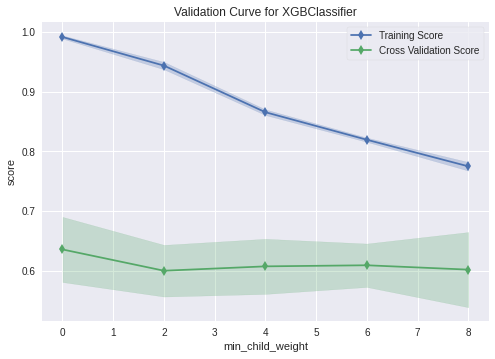

In [418]:
param_range = np.arange(0,10,2)

viz = ValidationCurve(
    xgb.XGBClassifier(ccp_alpha = 0.0, learning_rate =0.4,
                      min_weight_fraction_leaf = 0,
                      min_samples_split = 2,n_estimators= 100,
                      max_depth = 7, gamma = 0,subsample= 0.2, 
                      colsample_bytree = 0.4), 
    param_name="min_child_weight", 
    param_range=param_range,cv=5, 
    scoring="accuracy",
)

viz.fit(X, y)
viz.show()

In [419]:
clfXGBClass = xgb.XGBClassifier()

HyperparametersXGB = {
  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [420]:
clfXGBHy = RandomizedSearchCV(clfXGBClass ,HyperparametersXGB ,cv = 10, n_iter = 5)

clfXGBHy.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=XGBClassifier(), n_iter=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]})

In [421]:
y_predXGBHy = clfXGBHy.predict(X_test)

In [422]:
clfXGBHy.score(X_train, y_train)

0.9451697127937336

In [473]:
accuracyXGB = clfXGBHy.score(X_test, y_test)
accuracyXGB

0.6960486322188449

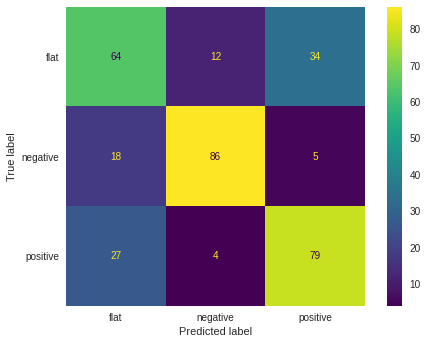

In [424]:
cm = confusion_matrix(y_test, y_predXGBHy)
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfXGBHy.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

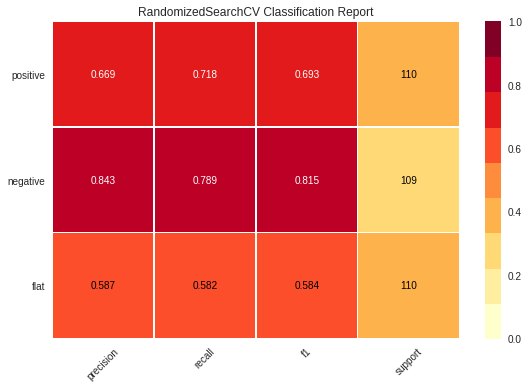

In [425]:
visualizer = ClassificationReport(clfXGBHy, classes = labelling.inverse_transform(clfXGBHy.classes_),  support=True)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()

In [426]:
Y_prob = clfXGBHy.predict_proba(X_test)
aucScoreXGB = roc_auc_score(y_test, Y_prob, multi_class = "ovo")
aucScoreXGB

0.8379681300073294

In [475]:
f1XGB = f1_score(y_test, y_predXGBHy, average= 'weighted')
f1XGB

0.697183550720612

neural network


In [427]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [445]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_dim = 6))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(3, activation = 'softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model


In [446]:
tuner = kt.RandomSearch(
    build_model,
    objective= 'val_accuracy',
    max_trials=50, )

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [447]:
tuner.search(X_train, y_train, epochs=20, validation_split=0.3)
best_model = tuner.get_best_models()[0]


INFO:tensorflow:Oracle triggered exit


In [448]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 448)               3136      
                                                                 
 dense_1 (Dense)             (None, 3)                 1347      
                                                                 
Total params: 4,483
Trainable params: 4,483
Non-trainable params: 0
_________________________________________________________________


In [449]:
best_model.fit(X_train, y_train, epochs=2000, batch_size= 1000)

Epoch 1/2000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 0s 397ms/step - loss: 0.9023 - accuracy: 0.5679
Epoch 2/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9169 - accuracy: 0.5587
Epoch 3/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9274 - accuracy: 0.5548
Epoch 4/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9093 - accuracy: 0.5548
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8939 - accuracy: 0.5783
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9082 - accuracy: 0.5757
Epoch 7/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9158 - accuracy: 0.5561
Epoch 8/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8986 - accuracy: 0.5914
Epoch 9/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8899 - accuracy: 0.6005
Epoch 10/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.9014 - accuracy: 0.5614
Epoch 11/2000
1/1 [===

In [450]:
yNNpredict = best_model.predict(X_test)

In [453]:
y_pred=np.argmax(yNNpredict, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

In [474]:
accuracyNN = accuracy_score(y_test, y_pred)
accuracyNN

0.6413373860182371

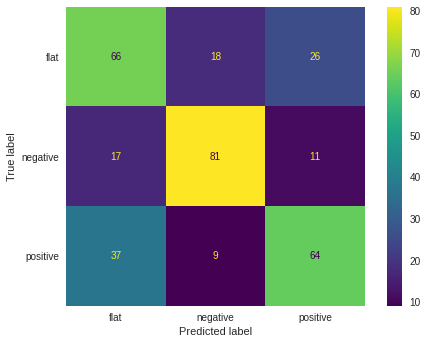

In [456]:
cmplot = ConfusionMatrixDisplay(cm, display_labels= labelling.inverse_transform(clfKnn.classes_))
cmplot.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

In [458]:
aucScoreNN = roc_auc_score(y_test, yNNpredict, multi_class = "ovo")
aucScoreNN

0.8069075239467233

In [481]:
f1NN = f1_score(y_test, y_pred, average= 'weighted')
f1NN

0.6420473084860634

In [490]:
metricsData = {
    "KNN" : [accuracyKNN, f1KNN, aucScoreKNN],
    "DT" : [accuracyDT, f1DT, aucScoreDT],
    "RF" : [accuracyRF, f1RF, aucScoreRF],
    "XGB" : [accuracyXGB, f1XGB, aucScoreXGB],
    "NN" : [accuracyNN, f1NN, aucScoreNN]
}

In [491]:
metricsDF = pd.DataFrame(metricsData,
                         index = pd.Index(['Accuracy', 'F1_Score', 'AUC_Score']),
                         columns = pd.Index(['KNN', 'DT', 'RF', 'XGB', 'NN'])).round(3)

In [495]:
metricsDF

KNN     DT     RF    XGB     NN
Accuracy   0.717  0.596  0.708  0.696  0.641
F1_Score   0.714  0.600  0.706  0.697  0.642
AUC_Score  0.788  0.679  0.855  0.838  0.807

In [497]:
readMeDF = metricsDF.to_html()

In [500]:
print(readMeDF)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>KNN</th>
      <th>DT</th>
      <th>RF</th>
      <th>XGB</th>
      <th>NN</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Accuracy</th>
      <td>0.717</td>
      <td>0.596</td>
      <td>0.708</td>
      <td>0.696</td>
      <td>0.641</td>
    </tr>
    <tr>
      <th>F1_Score</th>
      <td>0.714</td>
      <td>0.600</td>
      <td>0.706</td>
      <td>0.697</td>
      <td>0.642</td>
    </tr>
    <tr>
      <th>AUC_Score</th>
      <td>0.788</td>
      <td>0.679</td>
      <td>0.855</td>
      <td>0.838</td>
      <td>0.807</td>
    </tr>
  </tbody>
</table>


After looking at the various metrics we would be picking Random Forest

Pickling the Model

In [493]:
import pickle

In [494]:
filename = 'finalized_model.sav'
pickle.dump(clfRFHy, open(filename, 'wb'))